# CNN for the Classification of Chest X-ray Scans
---
In this notebook, we evaluate the results obtained by our model when classifieng chest x-ray scans for covid 19



In [ ]:
# Basic torch libraries
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor

# Python libraries for image processing and plotting
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [2]:
# Define which device is available: cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Download resnet 34 model from torchvision.models with pretrained weights
model_ft = models.resnet34(pretrained=True)

# Modify fully connected section of the model for our case (2 classes)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# Load pretrained weights
model_ft.load_state_dict(torch.load('checkpoint-best.pth'))
model_ft = model_ft.to(device)
classes = ["covid", "noCovid"]

In [3]:
def preprocess_img(image):
    '''
    Function used to preprocess image, following the transformations used in the training phase
    Args:
        image: Image to be preprocessed
    '''
    # Resize Image
    img = np.array(image.resize((255, 255)))  # uint8 with RGB mode
    img = img.astype(np.float32)
    h,w,_ = img.shape
    # Crop center
    img = img[15:h-15,15:2-15,:]
    value_scale = 255
    # Normalize image
    mean = [0.485, 0.456, 0.406]
    mean = [item * value_scale for item in mean]
    std =  [0.229, 0.224, 0.225]
    std = [item * value_scale for item in std]
    img = (img - mean) / std
    return img

def softmax(x):
    '''
    Softmax function that allows to compute probability from scores of several classes
    Args:
        x: vector containing scores for both classes
    Returns:
        vector of probabilities
    '''
    return np.exp(x)/np.sum(np.exp(x))

def predict_covid(img):
    '''
    Function where covid is predicted from chest xray scans
    Args:
        img: chest x-ray scan
    Returns:
        Prediction: covid/No_covid
        Probabilities: Vector of probabilities for each class
    '''
    model_ft.eval()
    image = ToTensor()(preprocess_img(img)).float().unsqueeze(0).to(device)
    output = model_ft(image)
    _, pred = torch.max(output, 1)
    return classes[pred], softmax(output.cpu().data.numpy())

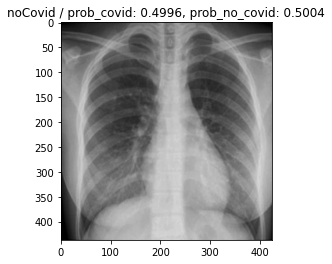

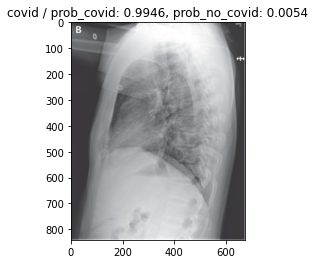

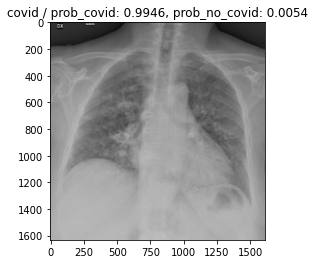

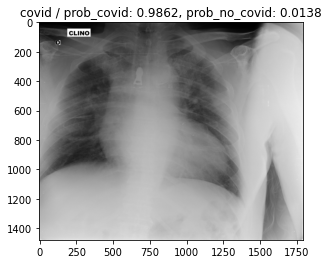

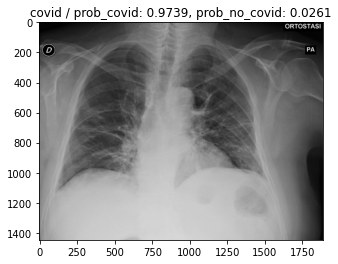

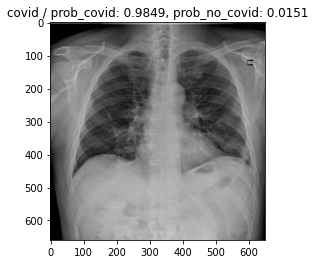

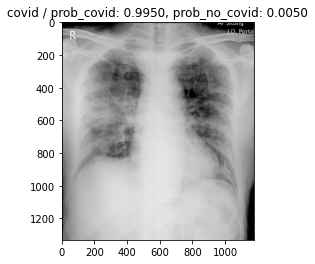

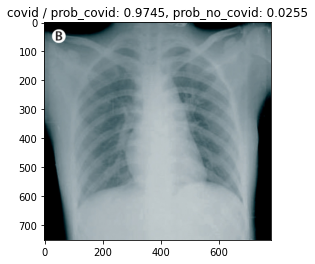

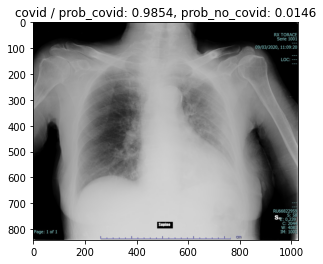

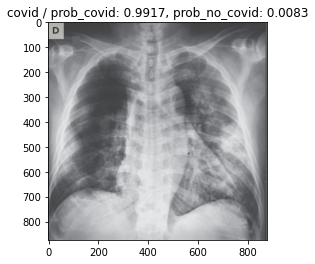

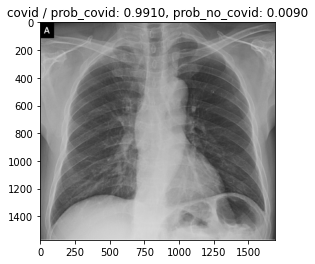

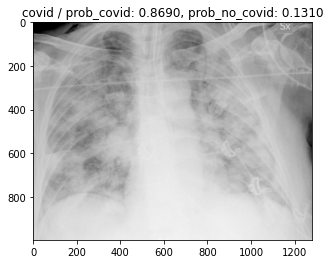

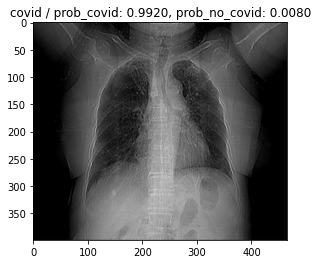

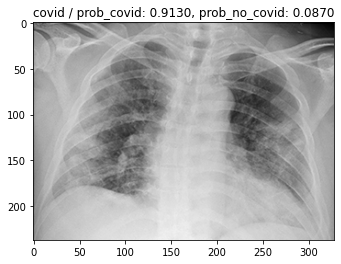

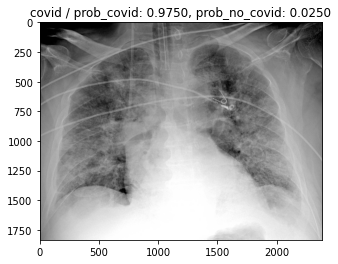

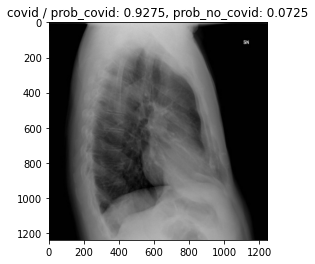

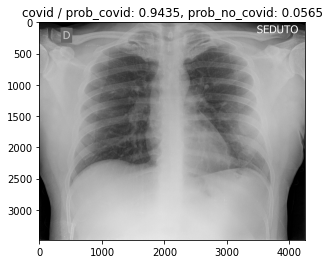

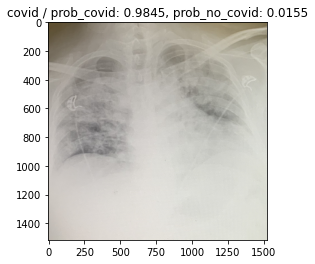

In [5]:
# Read test images from covid folder and perform predictions
total_imgs = 0
covid_positive = 0
for root, dirs, files in os.walk("data/test/covid", topdown=False):
    for name in files:
        total_imgs += 1
        #im_covid = Image.open("data/test/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg")
        img = Image.open(os.path.join(root, name))
        img = img.convert('RGB')
        fig, ax1 = plt.subplots(1,1)
        pred, probs = predict_covid(img)
        if (pred =='covid'):
            covid_positive += 1
        ax1.set_title("{} / prob_covid: {:.4f}, prob_no_covid: {:.4f}".format(pred, probs[0][0], probs[0][1]))
        ax1.imshow(img)
        plt.show()
print("Accuracy on covid positive test set: {}".format(covid_positive/total_imgs))

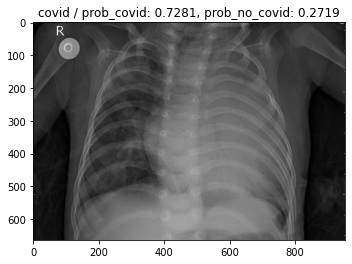

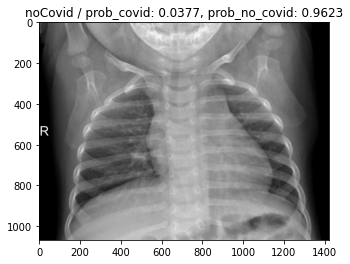

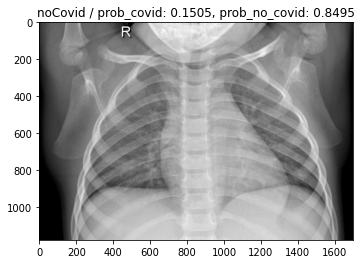

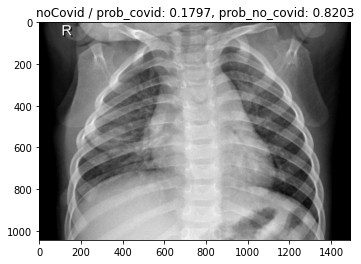

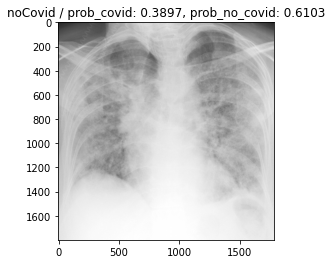

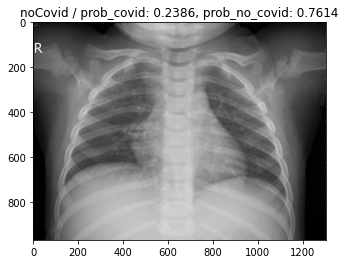

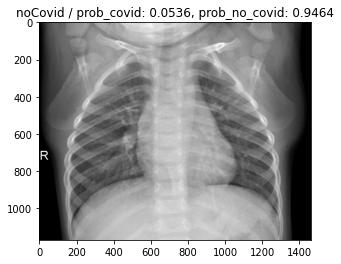

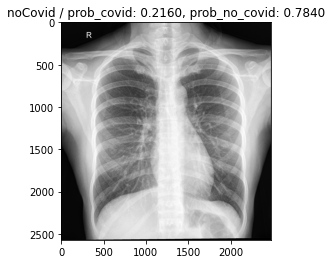

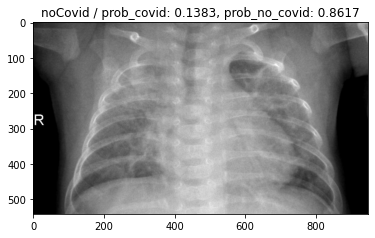

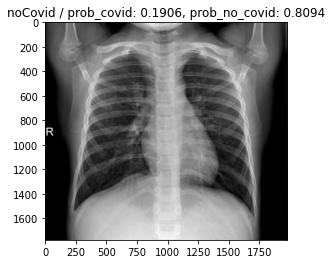

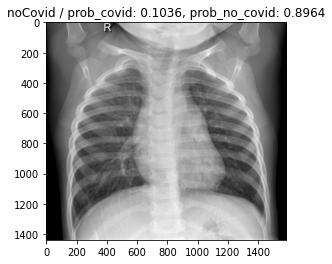

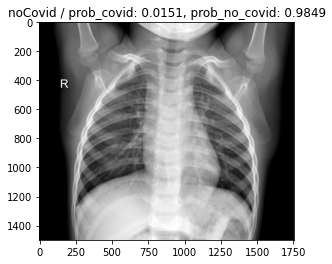

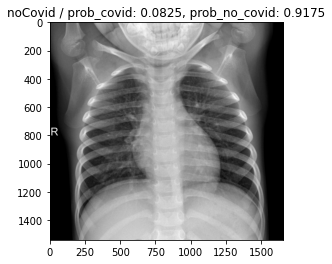

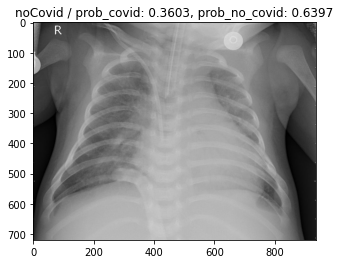

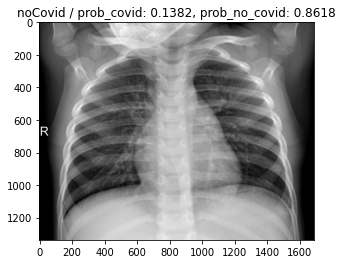

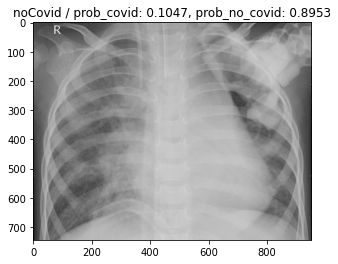

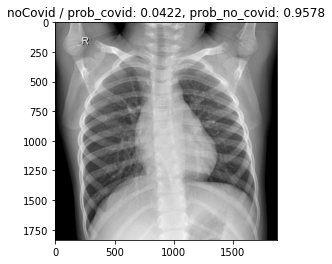

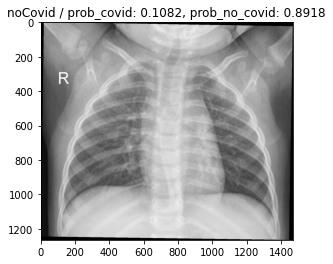

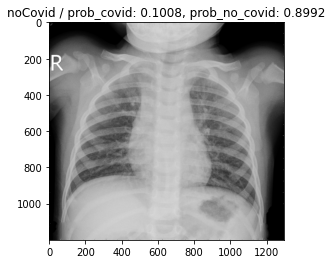

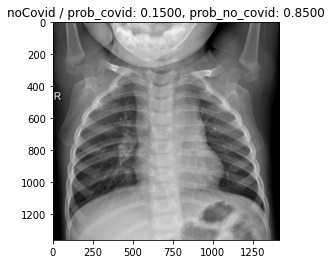

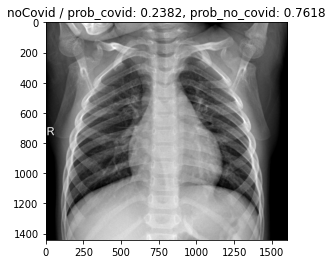

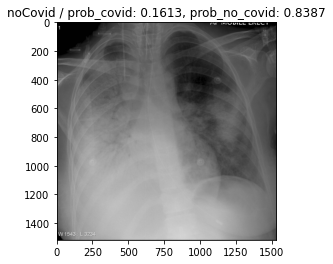

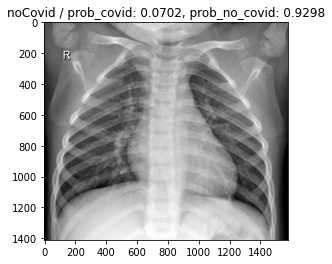

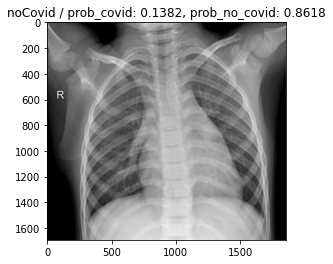

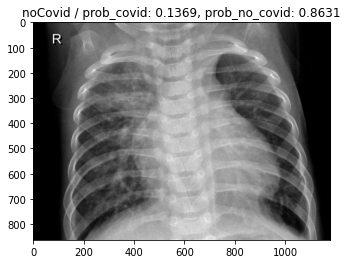

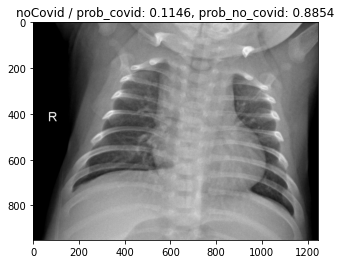

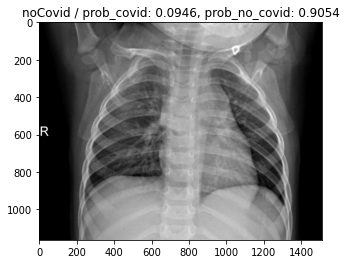

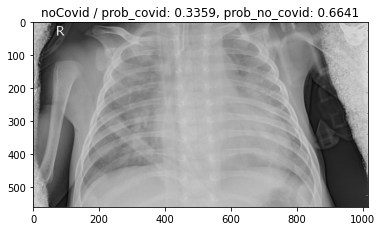

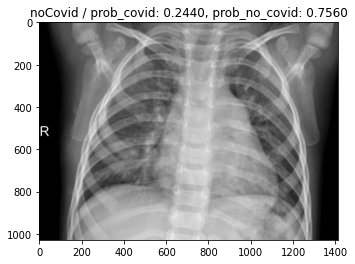

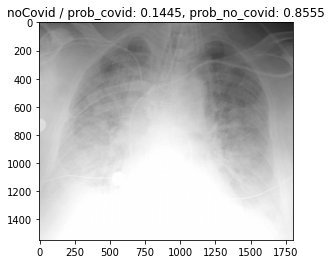

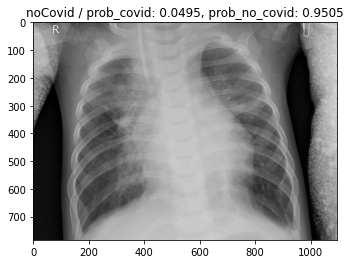

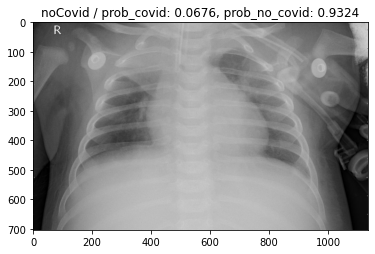

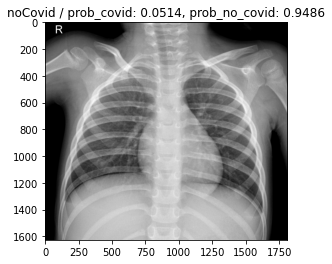

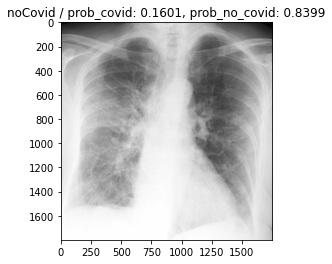

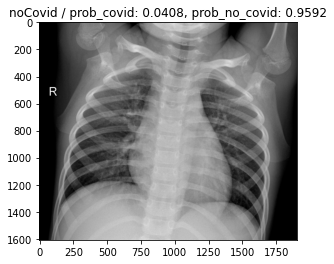

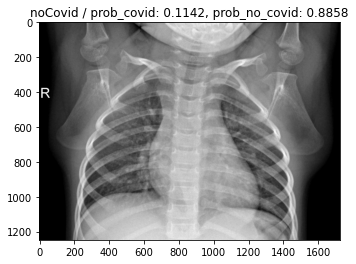

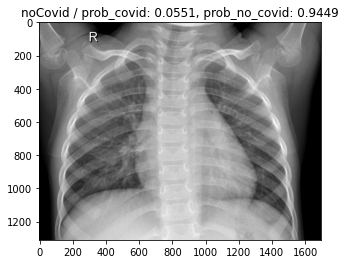

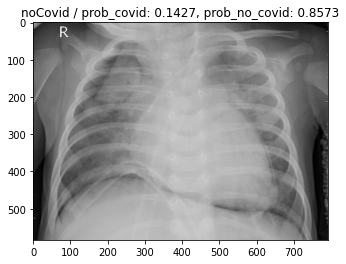

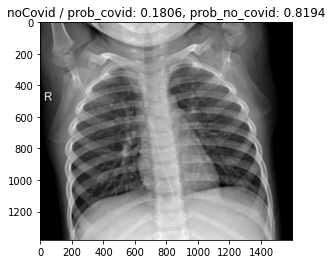

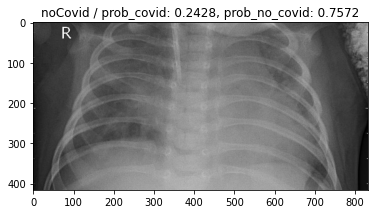

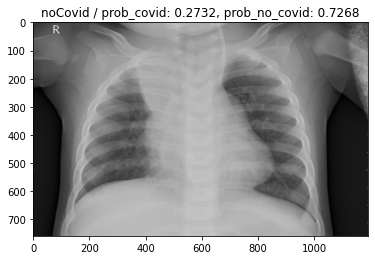

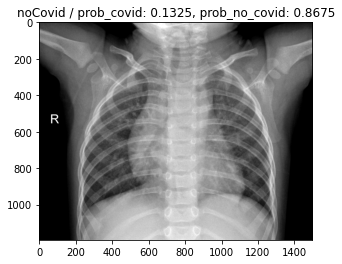

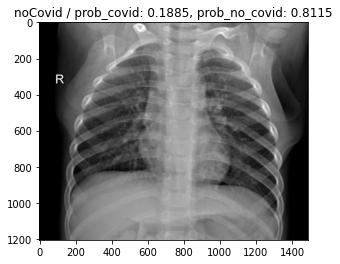

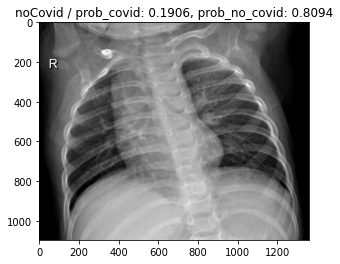

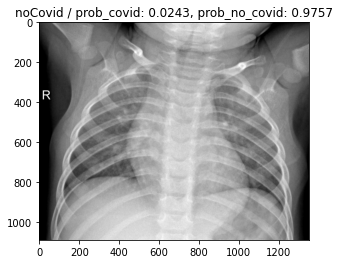

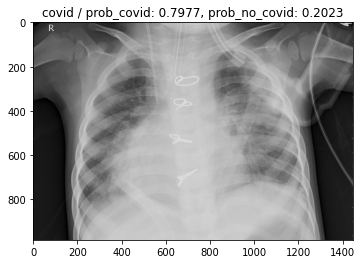

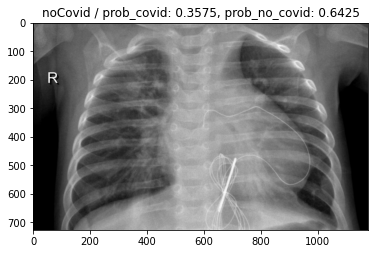

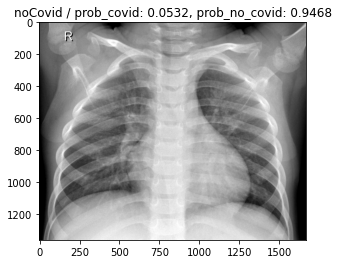

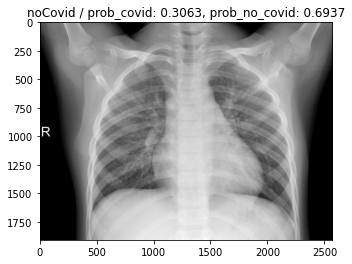

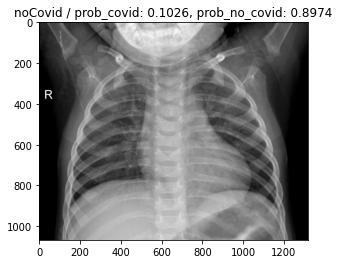

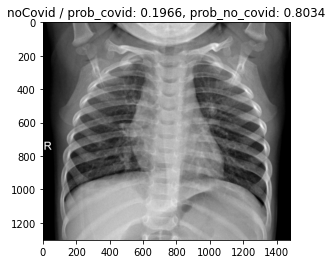

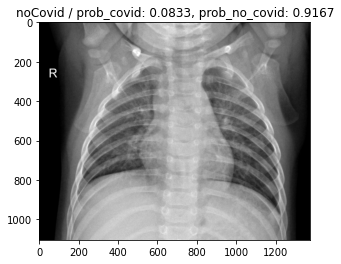

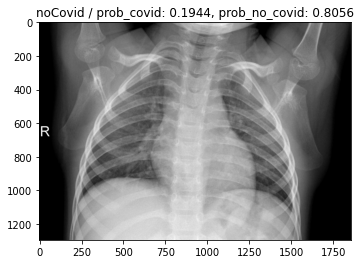

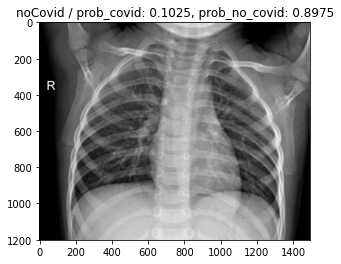

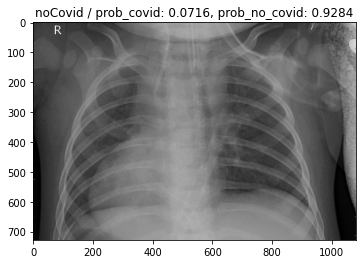

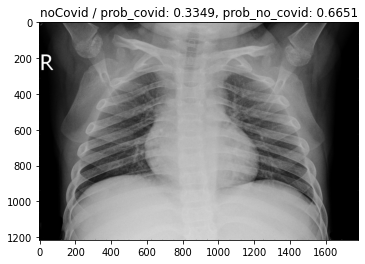

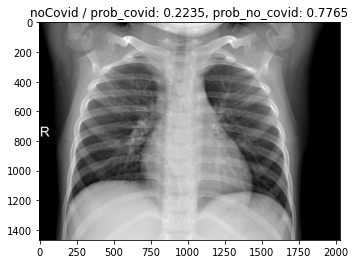

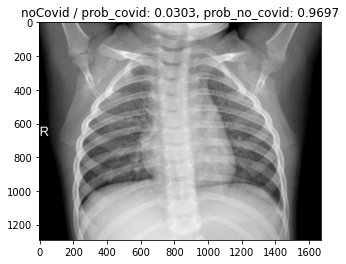

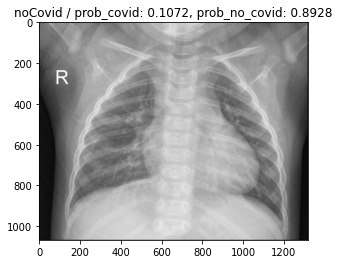

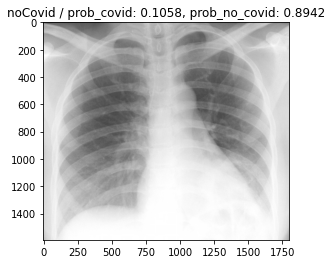

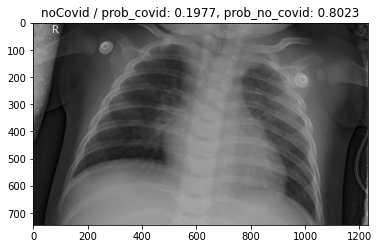

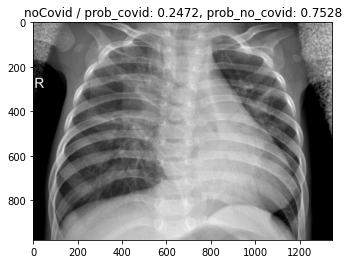

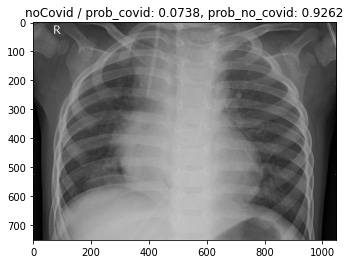

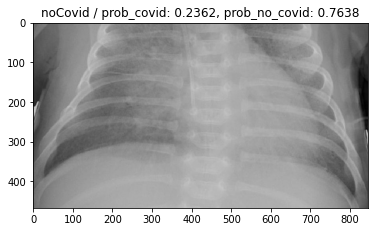

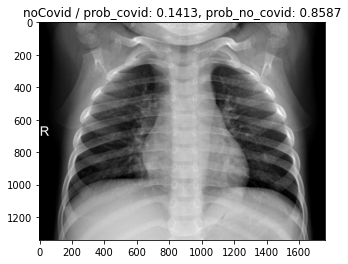

In [6]:
# Read test images from noCovid folder and perform predictions
total_imgs = 0
covid_negative = 0
for root, dirs, files in os.walk("data/test/noCovid", topdown=False):
    for name in files:
        total_imgs += 1
        img = Image.open(os.path.join(root, name))
        img = img.convert('RGB')
        fig, ax1 = plt.subplots(1,1)
        pred, probs = predict_covid(img)
        if (pred =='noCovid'):
            covid_positive += 1
        ax1.set_title("{} / prob_covid: {:.4f}, prob_no_covid: {:.4f}".format(pred, probs[0][0], probs[0][1]))
        ax1.imshow(img)
        plt.show()
print("Accuracy on covid negative test set: {}".format(covid_negative/total_imgs))